In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product


## Data Handling

In [2]:
# Import csv file from data folder
data = pd.read_csv('../Data/Price.csv')

# Explore data
print("Columns of dataset:", data.columns)
print("Price Areas: ", data['PriceArea'].unique())

# Filter all rows that do not equal DE for the column Country
data = data[data['PriceArea'] == 'DK2'].reset_index(drop=True) # adjust for DK2
data = data.drop(columns=['PriceDKK', 'PriceArea'])
data = data.rename(columns={'HourDK': 'Date', 'PriceEUR': 'Price', 'HourUTC': 'Hour'})
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')  # Convert to standard format
data['Hour'] = pd.to_timedelta(data['Hour']) + pd.Timedelta(hours=1) # Shift to UTC+1
data['Hour'] = data['Hour'].apply(lambda x: x - pd.Timedelta(days=1) if x >= pd.Timedelta(days=1) else x) # Handles the 24:00:00 case
data['Datetime'] = pd.to_datetime(data['Date']) + data['Hour']
data['Hour'] = data['Hour'].apply(lambda x: str(x).split(' ')[-1])
data['Hour'] = (pd.to_datetime(data['Hour'], format='%H:%M:%S')).dt.time
data.head(25)

Columns of dataset: Index(['HourUTC', 'HourDK', 'PriceArea', 'PriceDKK', 'PriceEUR'], dtype='object')
Price Areas:  ['DE' 'SE3' 'DK2' 'DK1' 'NO2' 'SE4' 'SYSTEM']


,Hour,Date,Price,Datetime
0,00:00:00,2021-01-01,50.869999,2021-01-01 00:00:00
1,01:00:00,2021-01-01,48.189999,2021-01-01 01:00:00
2,02:00:00,2021-01-01,44.680000,2021-01-01 02:00:00
3,03:00:00,2021-01-01,42.919998,2021-01-01 03:00:00
4,04:00:00,2021-01-01,40.389999,2021-01-01 04:00:00
5,05:00:00,2021-01-01,40.200001,2021-01-01 05:00:00
6,06:00:00,2021-01-01,39.630001,2021-01-01 06:00:00
7,07:00:00,2021-01-01,40.090000,2021-01-01 07:00:00
8,08:00:00,2021-01-01,41.270000,2021-01-01 08:00:00
9,09:00:00,2021-01-01,44.880001,2021-01-01 09:00:00


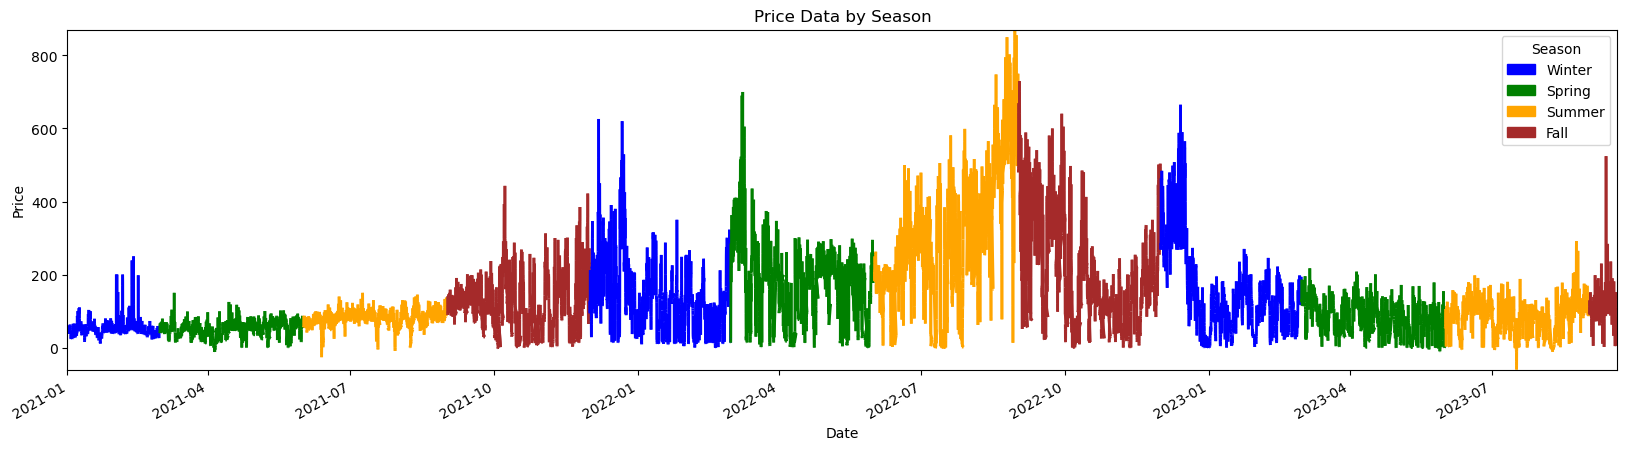

In [3]:
# Define seasons
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# Add a season column
data['Season'] = data['Datetime'].apply(get_season)

# Map seasons to colors
season_colors = {'Winter': 'blue', 'Spring': 'green', 'Summer': 'orange', 'Fall': 'brown'}
data['Color'] = data['Season'].map(season_colors)

# Prepare data for LineCollection
dates = data['Datetime'].values
prices = data['Price'].values
points = np.array([mdates.date2num(dates), prices]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
colors = data['Color'].values[:-1]  # Create color array for segments

# Create LineCollection
lc = LineCollection(segments, colors=colors, linewidths=2)

# Plot
fig, ax = plt.subplots(figsize=(20, 5))
ax.add_collection(lc)
ax.set_xlim(dates.min(), dates.max())
ax.set_ylim(prices.min(), prices.max())
ax.set_title('Price Data by Season')
ax.set_xlabel('Date')
ax.set_ylabel('Price')

# Format x-axis with proper dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()

# Create custom legend
legend_handles = [mpatches.Patch(color=color, label=season) for season, color in season_colors.items()]
ax.legend(handles=legend_handles, title='Season')
plt.show()

# Drop auxiliary columns
data = data.drop(columns=['Season', 'Color'])

## Price categorization

In [4]:
def dynamic_categorization(df, column, time_column, window_size):
    # Ensure the time column is sorted and in datetime format
    df[time_column] = pd.to_datetime(df[time_column])
    df = df.sort_values(by=[time_column, 'Hour'])

    # Compute rolling statistics (mean+std)
    df['RollingMean'] = df[column].rolling(window=window_size, min_periods=1).mean()
    df['RollingStd'] = df[column].rolling(window=window_size, min_periods=1).std() # 2 values needed for std -> first row will always be NaN!

    # Fill NaN std values with a small constant (e.g., 1) to avoid division errors
    df['RollingStd'] = df['RollingStd'].fillna(1)

    # Compute Z-scores
    df['ZScore'] = (df[column] - df['RollingMean']) / df['RollingStd']

    # Categorize based on Z-scores
    z_min, z_max = df['ZScore'].min(), df['ZScore'].max()
    bins = np.linspace(z_min - 0.1, z_max + 0.1, 6)  # Create 5 intervals

    labels = ['Very Low', 'Low', 'Normal', 'High', 'Very High']
    df['Category'] = pd.cut(df['ZScore'], bins=bins, labels=labels)
    

    return df

# Apply function to categorize
categorized_data = dynamic_categorization(data, column='Price', time_column='Date', window_size=168)
categorized_data.head(10)

,Hour,Date,Price,Datetime,RollingMean,RollingStd,ZScore,Category
0,00:00:00,2021-01-01,50.869999,2021-01-01 00:00:00,50.869999,1.000000,0.000000,Low
1,01:00:00,2021-01-01,48.189999,2021-01-01 01:00:00,49.529999,1.895046,-0.707107,Low
2,02:00:00,2021-01-01,44.680000,2021-01-01 02:00:00,47.913333,3.104260,-1.041579,Low
3,03:00:00,2021-01-01,42.919998,2021-01-01 03:00:00,46.664999,3.557757,-1.052630,Low
4,04:00:00,2021-01-01,40.389999,2021-01-01 04:00:00,45.409999,4.167535,-1.204549,Low
5,05:00:00,2021-01-01,40.200001,2021-01-01 05:00:00,44.541666,4.291701,-1.011642,Low
6,06:00:00,2021-01-01,39.630001,2021-01-01 06:00:00,43.840000,4.335350,-0.971086,Low
7,07:00:00,2021-01-01,40.090000,2021-01-01 07:00:00,43.371250,4.227060,-0.776249,Low
8,08:00:00,2021-01-01,41.270000,2021-01-01 08:00:00,43.137777,4.015609,-0.465129,Low
9,09:00:00,2021-01-01,44.880001,2021-01-01 09:00:00,43.312000,3.825829,0.409846,Normal


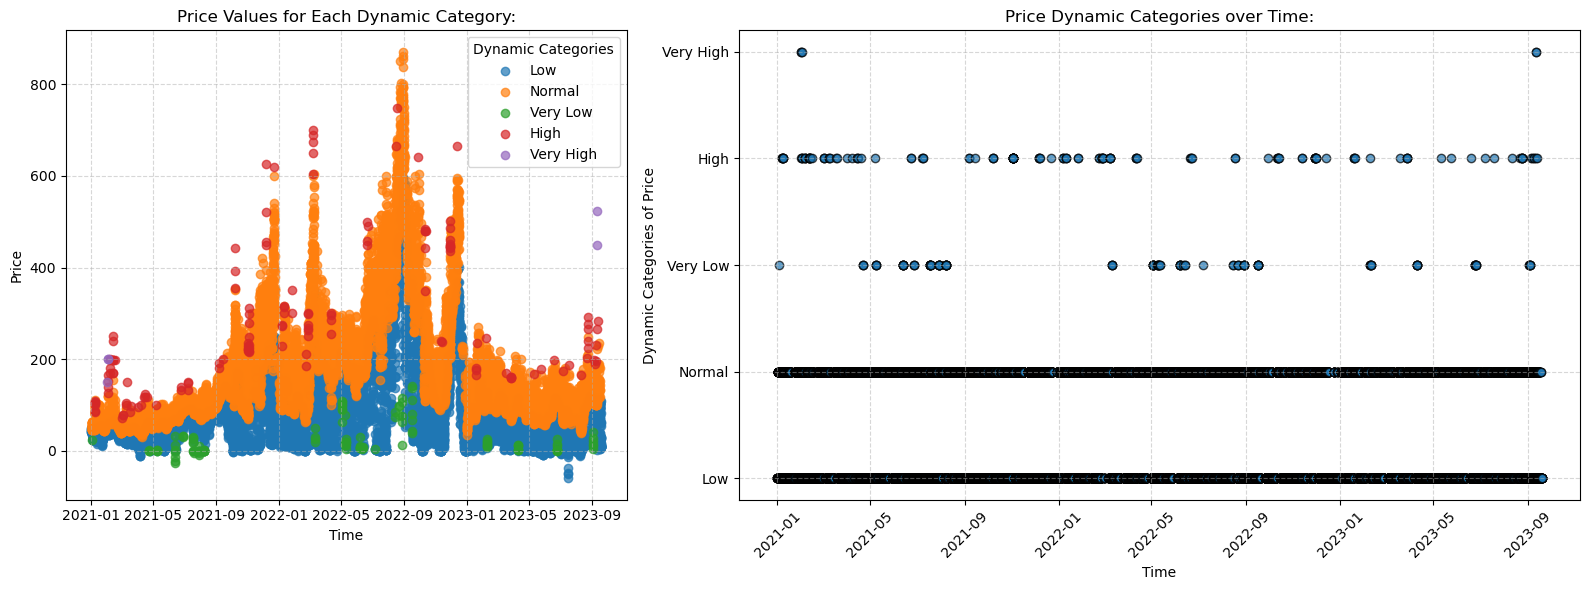

In [5]:
def plot_dynamic_categorization(df, column, time_column):
    """
    Create a subplot with the dynamically categorized data scatter plot on the right
    and line plots of the values for each dynamic category on the left.

    Parameters:
        df (pd.DataFrame): The input dataframe containing the categorized data.
        column (str): The column to analyze and plot.
        time_column (str): The time column to use for the x-axis.
    
    Returns:
        None: Displays a subplot with the categorized data and category-based line plots.
    """
    # Ensure time column is in datetime format and sorted
    df[time_column] = pd.to_datetime(df[time_column])
    df = df.sort_values(by=time_column)

    # Get unique categories for dynamic labeling
    unique_categories = df['Category'].dropna().unique()

    # Set up subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 3]})

    # Plot scatter plots of values for each dynamic category (left plot)
    for category in unique_categories:
        category_df = df[df['Category'] == category]
        axes[0].scatter(category_df[time_column], category_df[column], label=category, alpha=0.7)
    axes[0].set_title(f"{column} Values for Each Dynamic Category:")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel(column)
    axes[0].legend(title="Dynamic Categories")
    axes[0].grid(True, linestyle='--', alpha=0.5)

    # Plot scatter plot of dynamic categories over time (right plot)
    axes[1].scatter(df[time_column], df['Category'], alpha=0.7, edgecolor='k')
    axes[1].set_title(f"{column} Dynamic Categories over Time:")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel(f"Dynamic Categories of {column}")
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# Apply function to plot
plot_dynamic_categorization(categorized_data, column='Price', time_column='Datetime')

## Transition Matrix

In [6]:
def calculate_transition_matrix(df, category_column="Category"):
    """
    Calculate the transition probability matrix for categories.

    Args:
    - df: DataFrame with a sequential column of categories.
    - category_column: Name of the column containing the categories.

    Returns:
    - 4x4 transition probability matrix as a DataFrame.
    """
    # Ensure the column exists
    if category_column not in df.columns:
        raise ValueError(f"Column '{category_column}' not found in the DataFrame.")

    # Extract categories from input df

    categories = df[category_column].unique()
    transitions = df[category_column].values


    # Initialize a 4x4 matrix for counts
    transition_counts = pd.DataFrame(
        np.zeros((len(categories), len(categories))),
        index=categories,
        columns=categories,
    )

    # Count transitions
    for i in range(len(transitions) - 1):
        current_category = transitions[i]
        next_category = transitions[i + 1]
        if current_category in categories and next_category in categories:
            transition_counts.loc[current_category, next_category] += 1

    # Normalize rows to get probabilities
    transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0).fillna(0)

    return transition_matrix

# Calculate transition matrix
transition_matrix = calculate_transition_matrix(categorized_data)
transition_matrix

,Low,Normal,Very Low,High,Very High
Low,0.896437,0.100914,0.002649,0.000000,0.000000
Normal,0.099898,0.893244,0.000169,0.006603,0.000085
Very Low,0.273504,0.008547,0.717949,0.000000,0.000000
High,0.000000,0.531034,0.000000,0.455172,0.013793
Very High,0.000000,0.400000,0.000000,0.200000,0.400000


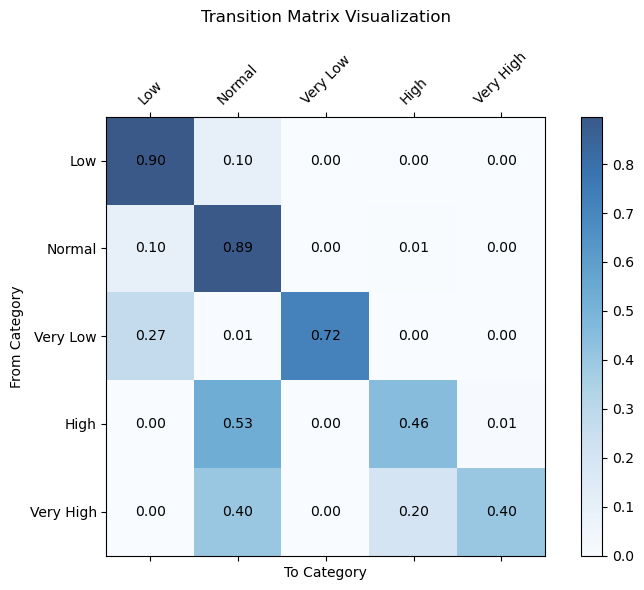

In [7]:
# Plotting the transition matrix
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(transition_matrix.values, cmap='Blues', alpha=0.8)

# Add text annotations
for (i, j), val in np.ndenumerate(transition_matrix.values):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

# Formatting the plot
plt.xticks(range(len(transition_matrix.columns)), transition_matrix.columns, rotation=45)
plt.yticks(range(len(transition_matrix.index)), transition_matrix.index)
plt.title("Transition Matrix Visualization", pad=20)
plt.xlabel("To Category")
plt.ylabel("From Category")
plt.colorbar(cax)
plt.tight_layout()
plt.show()



## MDP Model (using the value iteration algorithm to define the best policy)

In [8]:
class BatteryValueIteration:
    def __init__(self, soc_levels, actions, price_dict, price_series, price_categories, transition_matrix, gamma=0.9, epsilon=0.01, initial_SOC= 200):
        """
        Initialize the Battery Value Iteration problem.
        
        Args:
        - soc_levels: List of SOC levels (e.g., [0, 100, 200, ..., 500]).
        - actions: List of actions (e.g., ["Charge", "Discharge", "Nothing"]).
        - price_series: DataFrame with columns ['Hour', 'Category', 'Price'].
        - price_categories: List of unique price categories (e.g., ["Negative", "Low", "Medium", "High"]).
        - transition_matrix: Transition probability matrix (dict of dicts).
        - gamma: Discount factor (default 0.9).
        - epsilon: Convergence threshold for value iteration (default 0.01).
        """
        self.soc_levels = soc_levels
        self.actions = actions
        self.price_dict = price_dict
        self.price_cat_t = price_series['Category']
        self.price_t = price_series['Price']
        self.price_categories = price_categories
        self.transition_matrix = transition_matrix.T  # Transpose for correct indexing
        self.gamma = gamma
        self.epsilon = epsilon
        
        # Define all possible states as (SOC, PriceCategory)
        self.states = [(soc, category) for soc in soc_levels for category in price_categories]
        
        # Initialize value function and policy
        self.value_function = {state: 0 for state in self.states}
        self.policy = {state: "Nothing" for state in self.states}

        # Initialize state
        self.init_state = (initial_SOC, self.price_cat_t[0])


    def is_valid_action(self, soc, action):
        """Check if the action is valid given the SOC."""
        valid = not (
            (action == "Discharge" and soc == 0) or
            (action == "Charge" and soc == max(self.soc_levels))
        )
        #print(f"Action: {action}, SOC: {soc}, Valid: {valid}")  # Debugging action validity
        return valid

    def get_next_soc(self, soc, action):
        """Determine the next SOC based on the action."""
        if action == "Charge":
            return min(soc + 100, max(self.soc_levels))
        elif action == "Discharge":
            return max(soc - 100, 0)
        return soc

    def reward(self, action, price):
        """Calculate the reward for a given action and price."""
        if action == "Charge":
            return -100 * price  # Cost of charging
        elif action == "Discharge":
            return 100 * price  # Revenue from discharging
        return 0  # No cost/reward for doing nothing

    def value_iteration(self):
        """Perform the value iteration algorithm."""
        iteration = 0
        self.deltas = []
        
        while True:
            iteration += 1
            delta = 0  # Track convergence
            new_value_function = self.value_function.copy()

            for state in self.states:
                soc, price_category = state
                action_values = []
                action_feas = []

                for action in self.actions:
                    # Enforce validity check
                    if not self.is_valid_action(soc, action):
                        continue  ## to check
                    
                    #print(f"Feasible action {state, action}")
                    next_soc = self.get_next_soc(soc, action)
                    expected_value = 0

                    for next_category, prob in self.transition_matrix[price_category].items():
                        next_state = (next_soc, next_category)
                        if next_state in self.states:
                            reward = self.reward(action, self.price_dict[next_category])
                            expected_value += prob * (reward + self.gamma * self.value_function[next_state])

                    action_values.append(expected_value)
                    action_feas.append(action)

                # Debugging: Print state and valid actions
                #print(f"State: {state}, Valid Actions: {action_values}")

                # Update the value function and policy only if valid actions exist
                if action_values:
                    best_action_index = np.argmax(action_values)
                    new_value_function[state] = action_values[best_action_index]
                    self.policy[state] = action_feas[best_action_index]
                else:
                    # No valid actions; set default values
                    new_value_function[state] = self.value_function[state]
                    self.policy[state] = "Nothing"

                delta = max(delta, abs(new_value_function[state] - self.value_function[state]))

            self.value_function = new_value_function

            # Display convergence status
            #if iteration % 10 == 0:
                #print(f"Iteration {iteration}: Delta={delta}")
            self.deltas.append(delta)

            # Check for convergence
            if delta < self.epsilon:
                break

    def get_policy(self):
        """Return the computed policy."""
        return self.policy

    def get_value_function(self):
        """Return the computed value function."""
        return self.value_function
    
    def test_on_data(self, price_series):
        """Test the policy on a given price series."""
        self.rewards = []
        self.battery_actions = []
        reward_cumul = 0
        self.state = self.init_state
        for i in range(len(price_series) - 1):
            soc, price_category = self.state
            action = self.policy[self.state]
            reward = self.reward(action, self.price_t[i])
            reward_cumul += reward
            self.rewards.append(reward_cumul)
            self.battery_actions.append((self.state, action, self.price_t[i], price_category))
            next_soc = self.get_next_soc(soc, action)
            self.state = (next_soc, self.price_cat_t[i+1])
        
    


In [9]:
# SOC levels and actions
soc_levels = [0, 100, 200, 300, 400, 500]
actions = ["Charge", "Discharge", "Nothing"]
price_dict = {'Very Low': 0.1, 'Low': 0.3, 'Normal': 0.5, 'High': 0.7,  'Very High': 0.9}
price_categories = ['Very Low', 'Low', 'Normal', 'High', 'Very High']

# Initialize and run value iteration
optimizer = BatteryValueIteration(soc_levels, actions, price_dict, categorized_data, price_categories, transition_matrix, gamma=0.99, epsilon=0.1)
optimizer.value_iteration()
optimizer.test_on_data(categorized_data)


In [10]:
optimizer.battery_actions[:10]

[((200, 'Low'), 'Charge', 50.869999, 'Low'),
 ((300, 'Low'), 'Charge', 48.189999, 'Low'),
 ((400, 'Low'), 'Charge', 44.68, 'Low'),
 ((500, 'Low'), 'Nothing', 42.919998, 'Low'),
 ((500, 'Low'), 'Nothing', 40.389999, 'Low'),
 ((500, 'Low'), 'Nothing', 40.200001, 'Low'),
 ((500, 'Low'), 'Nothing', 39.630001, 'Low'),
 ((500, 'Low'), 'Nothing', 40.09, 'Low'),
 ((500, 'Low'), 'Nothing', 41.27, 'Low'),
 ((500, 'Normal'), 'Discharge', 44.880001, 'Normal')]

In [11]:
print("\nPolicy:")
for state, action in optimizer.get_policy().items():
    print(f"State: {state}, Policy: {action}")


Policy:
State: (0, 'Very Low'), Policy: Charge
State: (0, 'Low'), Policy: Charge
State: (0, 'Normal'), Policy: Nothing
State: (0, 'High'), Policy: Nothing
State: (0, 'Very High'), Policy: Nothing
State: (100, 'Very Low'), Policy: Charge
State: (100, 'Low'), Policy: Charge
State: (100, 'Normal'), Policy: Discharge
State: (100, 'High'), Policy: Discharge
State: (100, 'Very High'), Policy: Discharge
State: (200, 'Very Low'), Policy: Charge
State: (200, 'Low'), Policy: Charge
State: (200, 'Normal'), Policy: Discharge
State: (200, 'High'), Policy: Discharge
State: (200, 'Very High'), Policy: Discharge
State: (300, 'Very Low'), Policy: Charge
State: (300, 'Low'), Policy: Charge
State: (300, 'Normal'), Policy: Discharge
State: (300, 'High'), Policy: Discharge
State: (300, 'Very High'), Policy: Discharge
State: (400, 'Very Low'), Policy: Charge
State: (400, 'Low'), Policy: Charge
State: (400, 'Normal'), Policy: Discharge
State: (400, 'High'), Policy: Discharge
State: (400, 'Very High'), Polic

In [12]:
print("\nValue Function:")
for state, value in optimizer.get_value_function().items():
    print(f"State: {state}, Value: {value:.2f}")


Value Function:
State: (0, 'Very Low'), Value: 241.09
State: (0, 'Low'), Value: 200.15
State: (0, 'Normal'), Value: 180.74
State: (0, 'High'), Value: 177.16
State: (0, 'Very High'), Value: 176.41
State: (100, 'Very Low'), Value: 269.30
State: (100, 'Low'), Value: 235.10
State: (100, 'Normal'), Value: 228.87
State: (100, 'High'), Value: 236.82
State: (100, 'Very High'), Value: 246.41
State: (200, 'Very Low'), Value: 295.45
State: (200, 'Low'), Value: 269.17
State: (200, 'Normal'), Value: 275.29
State: (200, 'High'), Value: 289.96
State: (200, 'Very High'), Value: 305.00
State: (300, 'Very Low'), Value: 319.03
State: (300, 'Low'), Value: 302.46
State: (300, 'Normal'), Value: 320.07
State: (300, 'High'), Value: 339.11
State: (300, 'Very High'), Value: 357.11
State: (400, 'Very Low'), Value: 339.27
State: (400, 'Low'), Value: 335.04
State: (400, 'Normal'), Value: 363.28
State: (400, 'High'), Value: 385.51
State: (400, 'Very High'), Value: 405.21
State: (500, 'Very Low'), Value: 355.09
Sta

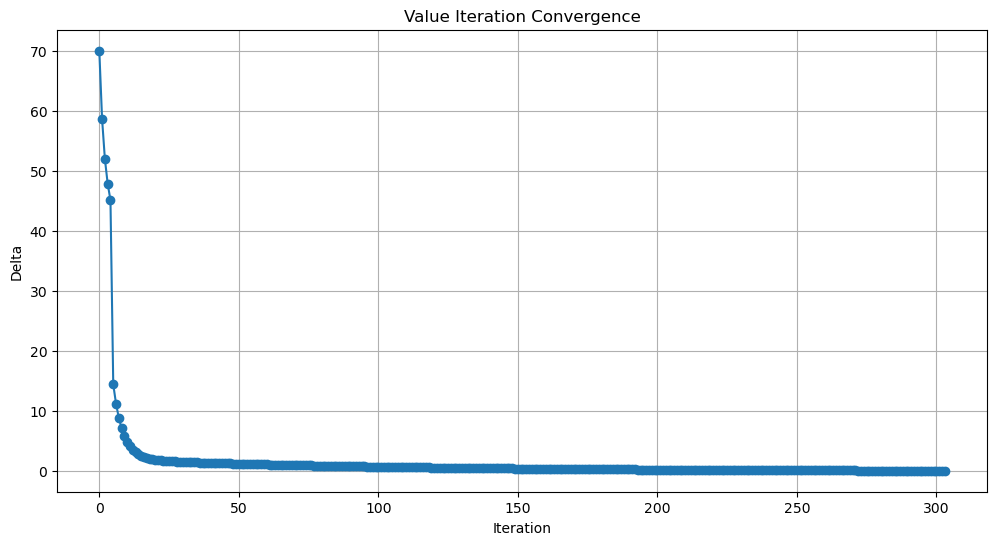

In [13]:
# Plot the deltas over the iterations
plt.figure(figsize=(12, 6))
plt.plot(optimizer.deltas, marker='o')
plt.title("Value Iteration Convergence")
plt.xlabel("Iteration")
plt.ylabel("Delta")
plt.grid(True)
plt.show()

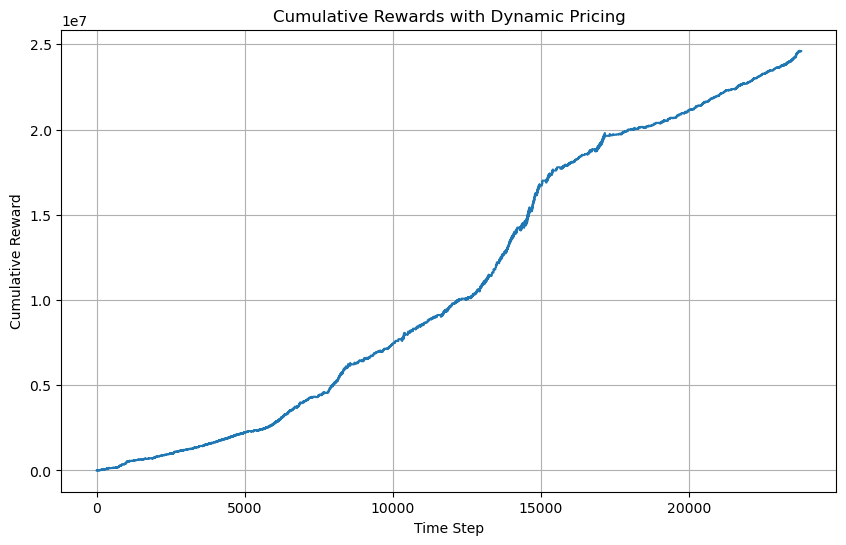

In [14]:
# Plot the rewards
plt.figure(figsize=(10, 6))
plt.plot(optimizer.rewards)
plt.title("Cumulative Rewards with Dynamic Pricing")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Reward")
plt.grid(True)
plt.show()

 ## MDP Model (using the policy iteration algorithm to define the best policy)

##### TODO

In [15]:
####Hyperparameter tuning

Starting Simplified Grid Search over 108 combinations...
Testing Config: {'rolling_window': 12, 'gamma': 0.98, 'num_classes': 4, 'epsilon': 0.05}
Reward: 23828533.01
Testing Config: {'rolling_window': 12, 'gamma': 0.98, 'num_classes': 4, 'epsilon': 0.1}
Reward: 23828533.01
Testing Config: {'rolling_window': 12, 'gamma': 0.98, 'num_classes': 4, 'epsilon': 0.2}
Reward: 23828533.01
Testing Config: {'rolling_window': 12, 'gamma': 0.98, 'num_classes': 5, 'epsilon': 0.05}
Reward: 20306592.05
Testing Config: {'rolling_window': 12, 'gamma': 0.98, 'num_classes': 5, 'epsilon': 0.1}
Reward: 20306592.05
Testing Config: {'rolling_window': 12, 'gamma': 0.98, 'num_classes': 5, 'epsilon': 0.2}
Reward: 20306592.05
Testing Config: {'rolling_window': 12, 'gamma': 0.98, 'num_classes': 6, 'epsilon': 0.05}
Reward: 18749572.01
Testing Config: {'rolling_window': 12, 'gamma': 0.98, 'num_classes': 6, 'epsilon': 0.1}
Reward: 18749572.01
Testing Config: {'rolling_window': 12, 'gamma': 0.98, 'num_classes': 6, 'eps

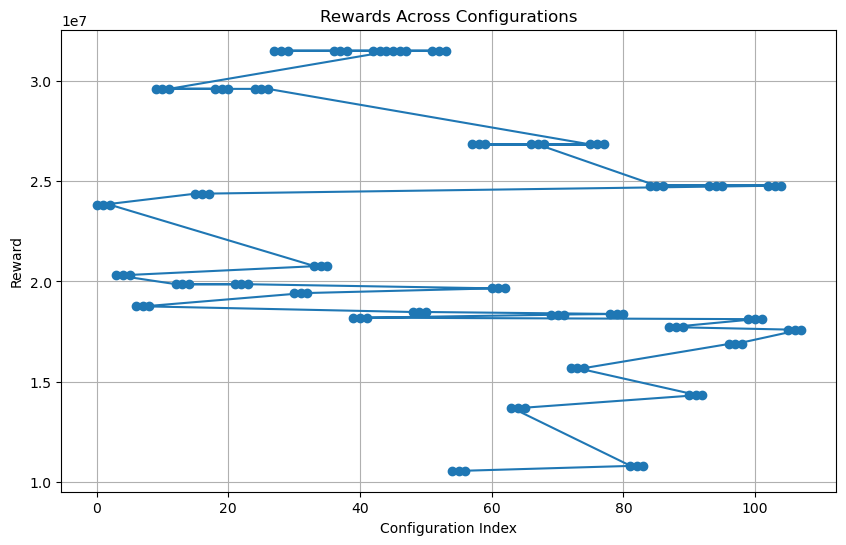

Top Configurations by Reward:
    rolling_window  gamma  num_classes  epsilon        reward
44              24  0.990            6     0.20  3.151547e+07
46              24  0.999            4     0.10  3.151547e+07
47              24  0.999            4     0.20  3.151547e+07
43              24  0.990            6     0.10  3.151547e+07
42              24  0.990            6     0.05  3.151547e+07


In [16]:

def simplified_grid_search(data, param_grid):
    """
    Perform grid search with selected parameters: rolling_window, gamma, num_classes, epsilon.

    Parameters:
    - data: Input dataset.
    - param_grid: Dictionary of parameter ranges.

    Returns:
    - DataFrame with sorted results by reward.
    """
    results = []
    param_names = list(param_grid.keys())
    param_combinations = list(product(*param_grid.values()))

    print(f"Starting Simplified Grid Search over {len(param_combinations)} combinations...")

    for combination in param_combinations:
        params = dict(zip(param_names, combination))
        print(f"Testing Config: {params}")

        # Perform dynamic categorization
        categorized_data = dynamic_categorization(data.copy(), 'Price', 'Date', params['rolling_window'])
        
        # Bin and label the data
        zscore_min = categorized_data['ZScore'].min()
        zscore_max = categorized_data['ZScore'].max()
        bins = np.linspace(zscore_min - 0.1, zscore_max + 0.1, params['num_classes'] + 1)
        labels = [f"Class_{i}" for i in range(params['num_classes'])]
        categorized_data['Category'] = pd.cut(categorized_data['ZScore'], bins=bins, labels=labels, include_lowest=True)

        # Skip configurations with invalid categories
        if categorized_data['Category'].isna().any():
            print(f"Skipping due to NaN categories: {params}")
            continue

        # Calculate transition matrix
        transition_matrix = calculate_transition_matrix(categorized_data, 'Category')
        if (transition_matrix.sum(axis=1) == 0).any():
            print(f"Skipping due to invalid transition matrix: {params}")
            continue

        # Run optimization
        soc_levels = [0, 100, 200, 300, 400, 500]
        actions = ["Charge", "Discharge", "Nothing"]
        price_dict = {label: i * 0.2 for i, label in enumerate(labels)}

        optimizer = BatteryValueIteration(
            soc_levels=soc_levels,
            actions=actions,
            price_dict=price_dict,
            price_series=categorized_data,
            price_categories=labels,
            transition_matrix=transition_matrix,
            gamma=params['gamma'],
            epsilon=params['epsilon']
            

        )
        optimizer.value_iteration()
        optimizer.test_on_data(categorized_data)

        final_reward = optimizer.rewards[-1] if optimizer.rewards else 0
        results.append({**params, 'reward': final_reward})
        print(f"Reward: {final_reward:.2f}")

    # Convert results to DataFrame
    results_df = pd.DataFrame(results).sort_values(by='reward', ascending=False)
    print("\nTop Configurations:")
    print(results_df.head(5))
    return results_df


# Define parameter grid
param_grid = {
    'rolling_window': [12, 24, 48, 72],  # Vary rolling windows
    'gamma': [0.98, 0.99, 0.999],  # Discount factor
    'num_classes': [4, 5, 6],  # Number of classes
    'epsilon': [0.05, 0.1, 0.2]  # Convergence threshold
}

# Run the grid search
results_df = simplified_grid_search(data, param_grid)

# Select top 5 configurations
top_5_configs = results_df.head(5).to_dict(orient='records')

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(results_df['reward'], marker='o')
plt.title("Rewards Across Configurations")
plt.xlabel("Configuration Index")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

# Print top configurations
print("Top Configurations by Reward:")
print(results_df.head(5))

## Evaluation

In [17]:
# Print top configurations
print("Top Configurations by Reward:")
print(results_df.head(20))

Top Configurations by Reward:
    rolling_window  gamma  num_classes  epsilon        reward
44              24  0.990            6     0.20  3.151547e+07
46              24  0.999            4     0.10  3.151547e+07
47              24  0.999            4     0.20  3.151547e+07
43              24  0.990            6     0.10  3.151547e+07
42              24  0.990            6     0.05  3.151547e+07
51              24  0.999            6     0.05  3.151547e+07
52              24  0.999            6     0.10  3.151547e+07
53              24  0.999            6     0.20  3.151547e+07
38              24  0.990            4     0.20  3.151547e+07
37              24  0.990            4     0.10  3.151547e+07
36              24  0.990            4     0.05  3.151547e+07
29              24  0.980            4     0.20  3.151547e+07
28              24  0.980            4     0.10  3.151547e+07
27              24  0.980            4     0.05  3.151547e+07
45              24  0.999            4  

In [18]:
# SOC levels and actions
soc_levels = [0, 100, 200, 300, 400, 500]
actions = ["Charge", "Discharge", "Nothing"]
price_dict = {'Very Low': 0.1, 'Low': 0.3, 'Normal': 0.5, 'High': 0.7,  'Very High': 0.9}
price_categories = ['Very Low', 'Low', 'Normal', 'High', 'Very High']

# Initialize and run value iteration
optimizer = BatteryValueIteration(soc_levels, actions, price_dict, categorized_data, price_categories, transition_matrix, gamma=0.99, epsilon=0.1)

In [19]:
class Expando(object):
    '''
        A small class which can have attributes set
    '''
    pass

In [20]:
import gurobipy as gp
from gurobipy import GRB

class OptimisationModel:
    def __init__(self, price_series, init_SOC=200, max_SOC=500, efficiency=1.0):
        self.price_t = price_series['Price']
        self.price_cat_t = price_series['Category']
        self.time = len(price_series)
        self.init_SOC = init_SOC
        self.max_SOC = max_SOC
        self.efficiency = efficiency  # Efficiency for charging/discharging
        
        self.results = {}
        self._build_model()
    
    def _build_model(self):
        self.m = gp.Model("Battery_Optimisation")
        
        # Decision Variables
        SOC = self.m.addVars(self.time, lb=0, ub=self.max_SOC, name="SOC")  # SOC level
        charge = self.m.addVars(self.time, lb=0, ub=1, vtype=GRB.BINARY, name="Charge")  # Charge binary
        discharge = self.m.addVars(self.time, lb=0, ub=1, vtype=GRB.BINARY, name="Discharge")  # Discharge binary

        # Constraints
        self.m.addConstr(SOC[0] == self.init_SOC, "InitialSOC")
        self.m.addConstrs(
            (SOC[i] == SOC[i - 1] + 100 * (charge[i] * self.efficiency - discharge[i] / self.efficiency)
             for i in range(1, self.time)), "SOC_Balance")
        self.m.addConstrs(
            (charge[i] + discharge[i] <= 1 for i in range(self.time)), "NoSimultaneousChargeDischarge")

        # Objective: Maximize rewards
        self.m.setObjective(
            gp.quicksum((discharge[i] * self.price_t[i] - charge[i] * self.price_t[i]) * 100 for i in range(self.time)),
            GRB.MAXIMIZE
        )

        # Solve
        self.m.optimize()

        # Store results
        self.results["objective"] = self.m.objVal
        self.results["SOC"] = [SOC[i].X for i in range(self.time)]
        self.results["charge"] = [charge[i].X for i in range(self.time)]
        self.results["discharge"] = [discharge[i].X for i in range(self.time)]
        self.results["rewards"] = self._compute_cumulative_rewards()

    def _compute_cumulative_rewards(self):
        """Compute cumulative rewards from the optimization results."""
        cumulative_rewards = []
        reward_cumul = 0
        for t in range(self.time):
            reward = (self.results["discharge"][t] * self.price_t[t] -
                      self.results["charge"][t] * self.price_t[t]) * 100
            reward_cumul += reward
            cumulative_rewards.append(reward_cumul)
        return cumulative_rewards


In [21]:
# Run the optimisation model
model = OptimisationModel(categorized_data)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-11
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 PRO 4750U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 47566 rows, 71349 columns and 142695 nonzeros
Model fingerprint: 0x817f6da4
Variable types: 23783 continuous, 47566 integer (47566 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 9e+04]
  Bounds range     [1e+00, 5e+02]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 14373.999800
Presolve removed 3 rows and 4 columns
Presolve time: 0.29s
Presolved: 47563 rows, 71345 columns, 142689 nonzeros
Variable types: 0 continuous, 71345 integer (47564 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 6.88s

In [22]:
# Compare Top 5 Configurations
def compare_top_5_with_optimization(data, top_5_configs, optimization_rewards):
    """
    Compare the rewards of the top 5 configurations with the optimization model reward over time.

    Parameters:
    - data: The dataset to use for categorization and testing.
    - top_5_configs: List of the top 5 configurations from hyperparameter tuning.
    - optimization_rewards: List of cumulative rewards from the optimization model.

    Returns:
    - A dictionary containing cumulative rewards and performance metrics for each top configuration.
    """
    soc_levels = [0, 100, 200, 300, 400, 500]
    actions = ["Charge", "Discharge", "Nothing"]
    top_configs_results = {}  # Store results for each configuration

    print("\nComparing Top 5 Configurations with Optimization Model:\n")

    for i, config in enumerate(top_5_configs):
        rolling_window = config['rolling_window']
        gamma = config['gamma']
        num_classes = config['num_classes']
        epsilon = config['epsilon']
        print(f"Processing Config {i + 1}: Rolling Window={rolling_window}, Gamma={gamma}, Num Classes={num_classes}")

        # Re-categorize the data with the specific rolling window
        categorized_data = dynamic_categorization(data.copy(), 'Price', 'Date', rolling_window)
        
        # Create bins and labels for categorization
        zscore_min = categorized_data['ZScore'].min()
        zscore_max = categorized_data['ZScore'].max()
        bins = np.linspace(zscore_min - 0.1, zscore_max + 0.1, num_classes + 1)
        labels = [f"Class_{i}" for i in range(num_classes)]
        categorized_data['Category'] = pd.cut(categorized_data['ZScore'], bins=bins, labels=labels, include_lowest=True)

        # Compute the transition matrix
        transition_matrix = calculate_transition_matrix(categorized_data, 'Category')

        # Initialize the optimizer with the specific gamma
        optimizer = BatteryValueIteration(
            soc_levels, actions, {label: i * 0.2 for i, label in enumerate(labels)},
            categorized_data, labels, transition_matrix, gamma=gamma, epsilon=epsilon
        )
        optimizer.value_iteration()
        optimizer.test_on_data(categorized_data)

        # Collect cumulative rewards for this configuration
        rewards = optimizer.rewards

        # Calculate percentage of total optimization reward
        final_reward_optimizer = rewards[-1] if rewards else 0
        final_reward_optimization = optimization_rewards[-1] if optimization_rewards else 1  # Avoid division by zero
        percentage_of_total = (final_reward_optimizer / final_reward_optimization) * 100

        print(f"Config {i + 1}:")
        print(f"  Final Reward: {final_reward_optimizer:.2f}")
        print(f"  Percentage of Optimal Reward: {percentage_of_total:.2f}%\n")

        # Save results
        top_configs_results[f"Config {i + 1}"] = {
            "rewards": rewards,
            "final_reward": final_reward_optimizer,
            "percentage_of_optimal": percentage_of_total,
        }

    return top_configs_results


Comparing Top 5 Configurations with Optimization Model:

Processing Config 1: Rolling Window=24, Gamma=0.99, Num Classes=6
Config 1:
  Final Reward: 31515472.04
  Percentage of Optimal Reward: 54.42%

Processing Config 2: Rolling Window=24, Gamma=0.999, Num Classes=4
Config 2:
  Final Reward: 31515472.04
  Percentage of Optimal Reward: 54.42%

Processing Config 3: Rolling Window=24, Gamma=0.999, Num Classes=4
Config 3:
  Final Reward: 31515472.04
  Percentage of Optimal Reward: 54.42%

Processing Config 4: Rolling Window=24, Gamma=0.99, Num Classes=6
Config 4:
  Final Reward: 31515472.04
  Percentage of Optimal Reward: 54.42%

Processing Config 5: Rolling Window=24, Gamma=0.99, Num Classes=6
Config 5:
  Final Reward: 31515472.04
  Percentage of Optimal Reward: 54.42%

Config 1 Results:
  - Final Reward: 31515472.04
  - Percentage of Optimal Reward: 54.42%
Config 2 Results:
  - Final Reward: 31515472.04
  - Percentage of Optimal Reward: 54.42%
Config 3 Results:
  - Final Reward: 315154

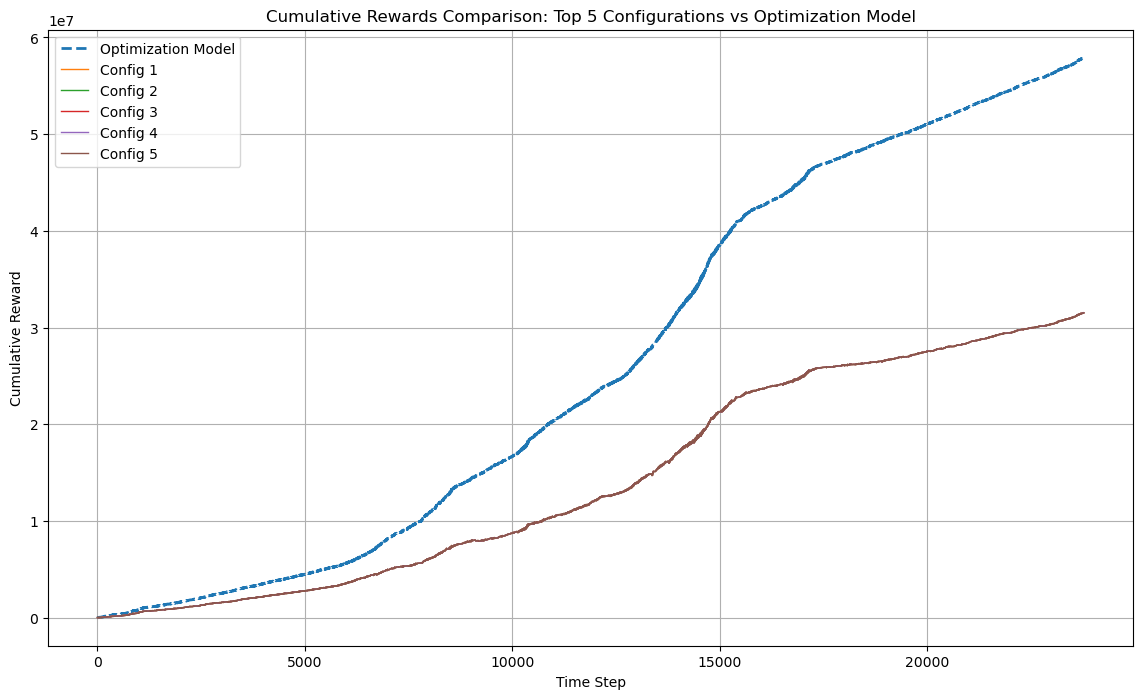

In [23]:
# Run the updated comparison function
top_configs_results = compare_top_5_with_optimization(data, top_5_configs, model.results["rewards"])

# Display the results
for config_name, results in top_configs_results.items():
    print(f"{config_name} Results:")
    print(f"  - Final Reward: {results['final_reward']:.2f}")
    print(f"  - Percentage of Optimal Reward: {results['percentage_of_optimal']:.2f}%")

# Plot cumulative rewards for top 5 configurations and the optimization model
plt.figure(figsize=(14, 8))
plt.plot(model.results["rewards"], label="Optimization Model", linewidth=2, linestyle="--")

# Add top 5 configurations to the plot
for config_name, results in top_configs_results.items():
    plt.plot(results['rewards'], label=config_name, linewidth=1)

# Formatting the plot
plt.title("Cumulative Rewards Comparison: Top 5 Configurations vs Optimization Model")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Reward")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [24]:
# Print the cumulative rewards of the optimisation model vs. the reinforcement learning model
plt.figure(figsize=(12, 6))
plt.plot(optimizer.rewards, label="Reinforcement Learning")
plt.plot(model.results["rewards"], label="Optimisation Model")
plt.title("Cumulative Rewards Comparison")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True)
plt.show()

AttributeError: 'BatteryValueIteration' object has no attribute 'rewards'

<Figure size 1200x600 with 0 Axes>

In [ ]:
pourcerntage_of_total = optimizer.rewards[len(optimizer.rewards)-1]/model.results["rewards"][len(model.results["rewards"])-1]
print("The Reinforcement Learning model has achieved", pourcerntage_of_total*100, "% of the total reward of the Optimisation Model")